In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras 
from collections import Counter
from wordcloud import WordCloud
import random
import os

import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import Pipeline


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (precision_score, recall_score, f1_score, classification_report, accuracy_score, confusion_matrix)
from sklearn.linear_model import LogisticRegression


import xgboost as xgb
from gensim.models import FastText, KeyedVectors
import fasttext

2025-07-12 20:36:34.693252: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-12 20:36:34.697582: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-12 20:36:34.733667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-12 20:36:34.733989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-12 20:36:34.735003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [4]:
# instantiate seed for reproducibility
os.environ['PYTHONHASHSEED'] = '3'
random.seed(3)
np.random.seed(3)
tf.random.set_seed(3)

In [7]:
df = pd.read_csv("dataset.csv")
df = df[['text_cleaned', 'labels']]
df.head(10)

,text_cleaned,labels
0,happy th birthday strength dedication skill sa...,1
1,greatest generations investment infrastructure...,1
2,thanks infrastructure investment jobs act auth...,0
3,get lasting change cant lock convicted crimes ...,1
4,today celebrating years hoosier state happy bi...,0
5,people act includes reforms popular americans ...,1
6,todays strong bipartisan vote beginningim goin...,1
7,supporting crime victims requires holding crim...,0
8,louisiana know natural disasters change lives ...,0
9,ill back grievances waste holiday cheer little...,0


In [10]:
df_train, df_test = train_test_split(df, test_size = 0.2, stratify=df['labels'], random_state=3)

y_train = df_train['labels']
y_test = df_test['labels']

In [13]:
#first we need to define the vocabulary using the training data only!

vocab = set()
total_words = 0
for text in df_train['text_cleaned']:
    if isinstance(text, str):
        for word in text.split(" "):
            total_words += 1
            vocab.add(word.strip())

print(f'Unique words in vocabulary: {len(vocab)}')
print(f'Total words (with repetition): {total_words}')

Unique words in vocabulary: 27094
Total words (with repetition): 446173


# Sparse Representation: TF-IDF

In [16]:
X_train = list(df_train['text_cleaned'])
X_test = list(df_test['text_cleaned'])

# TF-IDF stands for:
# TF = Term Frequency: how often a word appears in a document.
# IDF = Inverse Document Frequency: how rare a word is across all documents.
# a high TF-IDF value = a term that's frequent in this document and rare elsewhere

vectorizer = CountVectorizer(vocabulary = vocab) # matrix of token counts
transformer = TfidfTransformer()

# TD-IDF for training data
X_train = vectorizer.fit_transform(X_train)
X_tfidf_train = transformer.fit_transform(X_train)

# TD-IDF for test data
X_test = vectorizer.transform(X_test)
X_tfidf_test = transformer.transform(X_test)

print(X_tfidf_train.shape, X_tfidf_test.shape)

(23243, 27094) (5811, 27094)


## XGB vs Logistic Regression

In [19]:
# train and test for both models
X_tfidf_train
y_train = df_train['labels']

X_tfidf_test
y_test = df_test['labels']

In [22]:
# XGBOOST MODEL

pipe = Pipeline([
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=11,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc'
    ))
])

pipe.fit(X_train, y_train)

y_pred_class_xgb = pipe.predict(X_test)
y_pred_train_xgb = pipe.predict(X_train)

print('Train: {}'.format(accuracy_score(y_train, y_pred_train_xgb)))
print('Test: {}'.format(accuracy_score(y_test, y_pred_class_xgb)))

acc_train_xgb = accuracy_score(y_train, y_pred_train_xgb)
acc_test_xgb = accuracy_score(y_test, y_pred_class_xgb)
report_xgb = classification_report(y_test, y_pred_class_xgb)

print("XGBoost classification report:")
print(report_xgb)

conf_xgb = confusion_matrix(y_test, y_pred_class_xgb)
print(conf_xgb)

/root/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:37:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Train: 0.8230865206728908
Test: 0.7848907244880399
XGBoost classification report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      2763
           1       0.80      0.79      0.79      3048

    accuracy                           0.78      5811
   macro avg       0.78      0.78      0.78      5811
weighted avg       0.78      0.78      0.78      5811

[[2150  613]
 [ 637 2411]]


In [23]:
# LOGISTIC REGRESSION MODEL

pipe = Pipeline([
    ('model', LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        multi_class='auto'
    ))])

pipe.fit(X_train, y_train)

y_pred_class_log = pipe.predict(X_test)
y_pred_train_log = pipe.predict(X_train)

print('Train: {}'.format(accuracy_score(y_train, y_pred_train_log)))
print('Test: {}'.format(accuracy_score(y_test, y_pred_class_log)))

acc_train_log = accuracy_score(y_train, y_pred_train_log)
acc_test_log = accuracy_score(y_test, y_pred_class_log)
report_log = classification_report(y_test, y_pred_class_log)

print("Logistic Regression classification report:")
print(report_log)

conf_log = confusion_matrix(y_test, y_pred_class_log)
print(conf_log)

Train: 0.9665705803897948
Test: 0.837033212872139
Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2763
           1       0.85      0.84      0.84      3048

    accuracy                           0.84      5811
   macro avg       0.84      0.84      0.84      5811
weighted avg       0.84      0.84      0.84      5811

[[2304  459]
 [ 488 2560]]


# Dense representation: GloVe vs FastText

In [24]:
# Prepare tokenizer using the training text
tokenizer = Tokenizer(num_words=len(vocab), oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['text_cleaned'])

# Convert texts to sequences
sequences_train = tokenizer.texts_to_sequences(df_train['text_cleaned'])
sequences_test = tokenizer.texts_to_sequences(df_test['text_cleaned'])

In [25]:
print(sequences_train[0])

[682, 3631, 669, 1141, 478, 76, 595, 9038, 9039]


In [26]:
lengths = [len(seq) for seq in sequences_train]

# Inspect key statistics
print(f"Max length:       {np.max(lengths)}")
print(f"Mean length:      {np.mean(lengths):.1f}")
print(f"Std. dev:         {np.std(lengths):.1f}")
print(f"95th percentile:  {np.percentile(lengths, 95)}")
print(f"99th percentile:  {np.percentile(lengths, 99)}")

# Set maxlen based on the 95th percentile
max_len = int(np.percentile(lengths, 99))
vocab_size = len(vocab) + 1  # +1 for padding index

print(f"Using as max_len: {max_len}, and as vocab_size: {vocab_size}")

Max length:       48
Mean length:      19.2
Std. dev:         6.5
95th percentile:  28.0
99th percentile:  31.0
Using as max_len: 31, and as vocab_size: 27095


In [27]:
# Pad sequences to the same length
X_seq_train = pad_sequences(sequences_train, maxlen=max_len, padding='post')
X_seq_test = pad_sequences(sequences_test, maxlen=max_len, padding='post')

print(f"Shape of X_seq_train: {X_seq_train.shape}")
print(f"Shape of X_seq_test: {X_seq_test.shape}")

Shape of X_seq_train: (23243, 31)
Shape of X_seq_test: (5811, 31)


## GloVe

In [28]:
glove_file_path = "glove/glove.6B.100d.txt"

if not os.path.exists(glove_file_path):
    print("Downloading GloVe...")
    !wget http://nlp.stanford.edu/data/glove.6B.zip -P glove/
    !unzip glove/glove.6B.zip -d glove/
else:
    print("Glove downloaded!")


embedding_index_gv = {}
with open("/work/glove/glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index_gv[word] = coefs

Glove downloaded!


In [29]:
embedding_dim = 100
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

embedding_matrix_gv = np.zeros((vocab_size, embedding_dim))
found = 0
not_found = 0
oov_words = []

for word, i in word_index.items():
    embedding_vector = embedding_index_gv.get(word)
    if embedding_vector is not None:
        embedding_matrix_gv[i] = embedding_vector
        found += 1
    else:
        not_found += 1
        oov_words.append(word)

print(f"Total vocabulary size: {vocab_size}")
print(f"Words found in GloVe: {found}")
print(f"OOV words: {not_found}")
print(f"Example of OOV words: {oov_words[:20]}")

Total vocabulary size: 27096
Words found in GloVe: 20938
OOV words: 6157
Example of OOV words: ['<OOV>', 'covid', 'shouldnt', 'goodpaying', 'icymi', 'theyve', 'muchneeded', 'whove', 'taxandspend', 'pfas', 'aapi', 'arizonas', 'lowincome', 'communitybased', 'youve', 'bidenharris', 'highquality', 'inperson', 'theyll', 'iowas']


In [30]:
# Example
word = "trump"
embedding_vector = embedding_index_gv.get(word) 
print(f'embedding for the word {word}: {embedding_vector}')

embedding for the word trump: [-0.15731  -0.75503   0.36845  -0.18958  -0.16896  -0.23157  -0.22658
 -0.30186   0.24372   0.61896   0.58995   0.047638 -0.055164 -0.70211
  0.22084  -0.69232   0.49419   1.4285   -0.25362   0.20031  -0.26192
  0.05315  -0.048418 -0.44982   0.54644  -0.014645 -0.015531 -0.61197
 -0.91964  -0.7528    0.64843   1.0934    0.052682  0.33345   0.10532
  0.59517   0.023104 -0.37105   0.29749  -0.23683   0.079566 -0.10326
  0.35885  -0.28935  -0.19881   0.22908  -0.061435  0.56127  -0.017115
 -0.32868  -0.78417  -0.49375   0.34944   0.16278  -0.061168 -1.3106
  0.39152   0.124    -0.20873  -0.18473  -0.56184   0.55693   0.012114
 -0.54545  -0.31409   0.1       0.31543   0.74757  -0.47734  -0.18332
 -0.65623   0.40768  -0.30697  -0.47247  -0.7421   -0.44978  -0.078122
 -0.52673  -0.70633   1.3271    0.26298  -0.91      0.91632  -0.51643
  0.20284  -0.25402  -1.2566    0.20271   0.92105  -0.57574  -0.15105
 -0.24831   0.36673  -0.53987   0.18534   0.25713   0.3879

## FastText

In [31]:
model_path = "fastText/fasttext_CAPITOL.model"

if os.path.exists(model_path):
    print("Model found, loading from file...")
    ft_model = FastText.load(model_path)
else:
    print("Model not found, training from scratch...")
    sentences = [text.split() for text in df_train['text_cleaned'] if isinstance(text, str)]
    ft_model = FastText(
        sentences=sentences,
        vector_size=100,
        window=5,
        min_count=2,
        workers=4,
        sg=1,
        epochs=10
    )
    ft_model.save(model_path)
    print("Model trained and saved!")

Model found, loading from file...


In [32]:
embedding_dim = 100
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

embedding_matrix_ft = np.zeros((vocab_size, embedding_dim))
found = 0
not_found = 0
oov_words = []

for word, i in word_index.items():
    if word in ft_model.wv:
        embedding_matrix_ft[i] = ft_model.wv[word]
        found += 1
    else:
        # FastText can generalize better with OOV words
        try:
            embedding_matrix_ft[i] = ft_model.wv.get_vector(word)
            found += 1
        except KeyError:
            not_found += 1
            oov_words.append(word)

In [33]:
# Example
word = 'trump'
embedding_vector= ft_model.wv['trump']
print(f'embedding for the word {word}: {embedding_vector}')
print(ft_model.wv.most_similar(word))

embedding for the word trump: [ 0.07628009 -0.04653428 -0.6655145   0.8750356  -0.47947592  0.72240853
 -0.48577815 -0.20008463  0.00422663 -0.6464558   0.08813871  0.5538863
 -0.74165815  0.24181382  0.02519122 -0.14671952 -0.49653623  0.00445896
 -0.14829177  0.01358375 -0.14617331  0.16717222  0.04821078 -0.2878098
 -0.11177079  0.13764971  0.2398807  -0.3056377  -0.29453483 -0.37330845
 -0.3105566   0.31453082  0.07617046 -0.31131795 -0.63108337 -0.15868673
  0.3088605  -0.1532657  -0.19483252  0.3705447  -0.26137727 -1.0581553
 -0.66976327 -0.01721814  0.08029409 -0.22779961 -0.15439469 -0.40577397
 -0.06200251 -0.36757573  0.40790257  0.09082329  1.0566207   0.42300528
  0.33719492  0.02723759  0.04207134 -0.7167158  -0.5383369  -0.3841733
  0.1765335   0.20121951 -0.42517656  0.53219473 -0.09794184 -0.14777955
  0.0230848   0.46410996 -0.00490367  0.24992973  0.30398378 -0.5477953
  0.62886024 -0.66787565  0.19544366 -0.12170073  0.4077777  -0.44721338
 -0.26218906  0.36373505 -

# RNN MODEL

In [34]:
def create_model(embedding_matrix, 
                 LOSS = 'binary_crossentropy',
                 learning_rate=0.01,
                 hidden_act='relu',
                 dropout_rate=0.2):

    text_input = Input(shape=(max_len,), name='text_input')

    # Embedding layer suitable for both GloVe and FastText
    embedding = Embedding(input_dim=vocab_size,
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False,
                        name='embedding')(text_input)
    # RNN layer
    lstm = LSTM(units=128,
             activation='tanh',
             recurrent_activation='sigmoid',
             kernel_initializer='glorot_uniform',
             return_sequences=False,
             name='lstm')(embedding)

    # Dense layers with dropout
    x = Dense(64, activation=hidden_act, kernel_initializer='he_uniform', kernel_regularizer='l2')(lstm)
    x = Dropout(dropout_rate)(x)

    x = Dense(32, activation=hidden_act, kernel_initializer='he_uniform', kernel_regularizer='l2')(x)
    x = Dropout(dropout_rate)(x)

    # Output layer for binary classification
    output = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=text_input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=LOSS,
        metrics=['accuracy']
    )

    return model

In [35]:
def model_train_and_eval(model):

    history = model.fit(
        x=X_seq_train,
        y=y_train,
        epochs=10,
        batch_size=64,
        verbose=1,
        validation_split=0.2
    )

    loss, accuracy = model.evaluate(x=X_seq_test, y=y_test, batch_size=64, verbose=1)
    print(f"\nTest Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    y_pred_prob = model.predict(X_seq_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {acc:.4f}")

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dem', 'Rep'], yticklabels=['Dem', 'Rep'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return history

Epoch 1/10
291/291 [==============================] - 11s 31ms/step - loss: 0.6809 - accuracy: 0.6729 - val_loss: 0.5435 - val_accuracy: 0.7533
Epoch 2/10
291/291 [==============================] - 8s 28ms/step - loss: 0.5133 - accuracy: 0.7704 - val_loss: 0.4820 - val_accuracy: 0.7793
Epoch 3/10
291/291 [==============================] - 8s 26ms/step - loss: 0.4488 - accuracy: 0.8093 - val_loss: 0.4534 - val_accuracy: 0.7922
Epoch 4/10
291/291 [==============================] - 8s 28ms/step - loss: 0.3942 - accuracy: 0.8376 - val_loss: 0.4407 - val_accuracy: 0.8021
Epoch 5/10
291/291 [==============================] - 9s 29ms/step - loss: 0.3514 - accuracy: 0.8623 - val_loss: 0.4892 - val_accuracy: 0.8015
Epoch 6/10
291/291 [==============================] - 8s 28ms/step - loss: 0.3350 - accuracy: 0.8723 - val_loss: 0.4978 - val_accuracy: 0.8064
Epoch 7/10
291/291 [==============================] - 10s 34ms/step - loss: 0.2903 - accuracy: 0.8967 - val_loss: 0.4581 - val_accuracy: 0.80

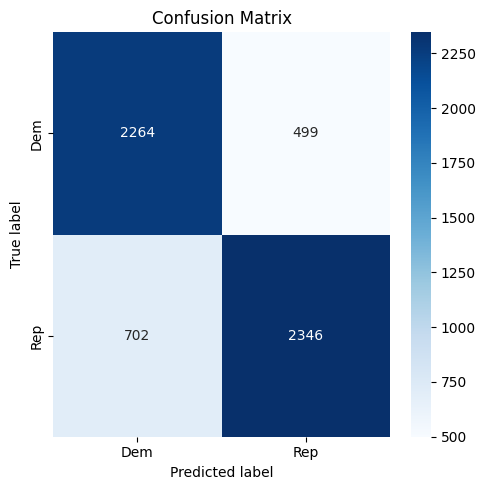

In [39]:
model_gv = create_model(embedding_matrix_gv)
history_gv = model_train_and_eval(model_gv)

Epoch 1/10
291/291 [==============================] - 11s 30ms/step - loss: 0.6503 - accuracy: 0.6967 - val_loss: 0.5480 - val_accuracy: 0.7230
Epoch 2/10
291/291 [==============================] - 9s 30ms/step - loss: 0.4907 - accuracy: 0.7783 - val_loss: 0.4721 - val_accuracy: 0.7995
Epoch 3/10
291/291 [==============================] - 9s 29ms/step - loss: 0.4571 - accuracy: 0.8010 - val_loss: 0.4499 - val_accuracy: 0.7995
Epoch 4/10
291/291 [==============================] - 9s 30ms/step - loss: 0.4283 - accuracy: 0.8135 - val_loss: 0.4167 - val_accuracy: 0.8101
Epoch 5/10
291/291 [==============================] - 9s 29ms/step - loss: 0.3898 - accuracy: 0.8325 - val_loss: 0.4190 - val_accuracy: 0.8090
Epoch 6/10
291/291 [==============================] - 9s 30ms/step - loss: 0.3675 - accuracy: 0.8417 - val_loss: 0.4086 - val_accuracy: 0.7974
Epoch 7/10
291/291 [==============================] - 9s 30ms/step - loss: 0.3462 - accuracy: 0.8505 - val_loss: 0.4110 - val_accuracy: 0.815

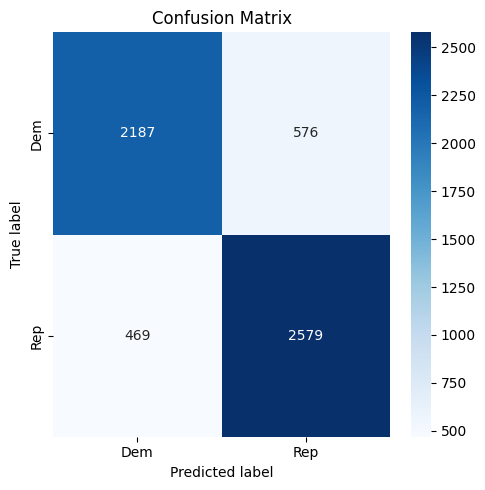

In [38]:
model_ft = create_model(embedding_matrix_ft)
history_ft = model_train_and_eval(model_ft)

# FINAL EVALUATION

182/182 [==============================] - 2s 8ms/step


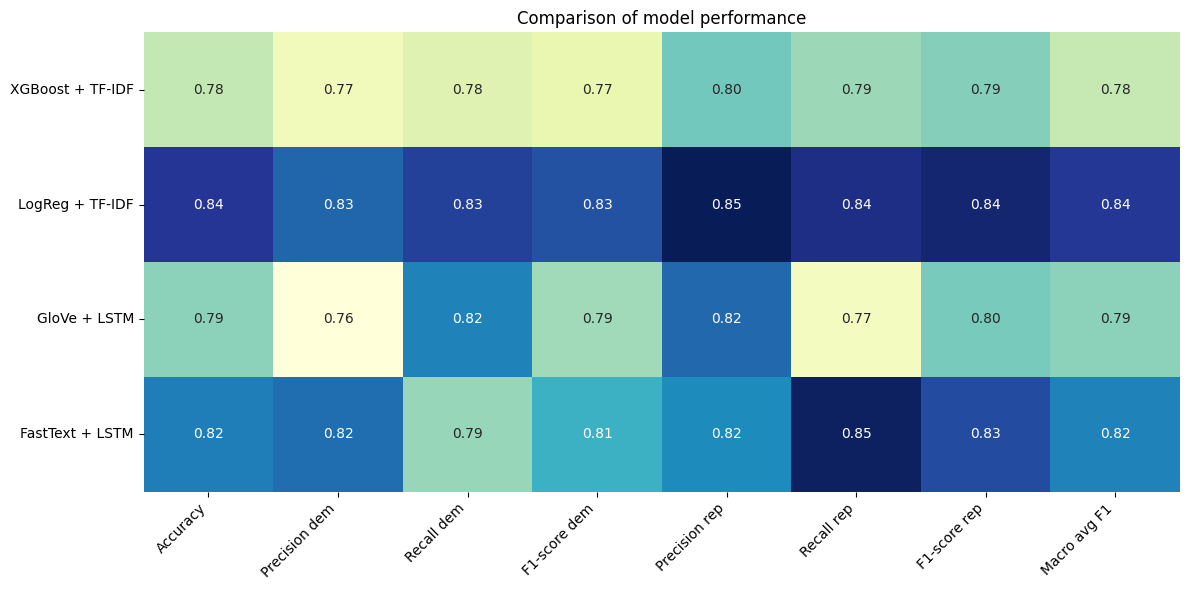

In [43]:
results = {}

# TF-IDF + XGBoost
results['XGBoost + TF-IDF'] = classification_report(y_test, y_pred_class_xgb, output_dict=True)
results['XGBoost + TF-IDF']['accuracy'] = acc_test_xgb

# TF-IDF + Logistic Regression
results['LogReg + TF-IDF'] = classification_report(y_test, y_pred_class_log, output_dict=True)
results['LogReg + TF-IDF']['accuracy'] = acc_test_log

# GloVe + LSTM
y_pred_prob_gv = model_gv.predict(X_seq_test)
y_pred_gv = (y_pred_prob_gv > 0.5).astype(int).flatten()
results['GloVe + LSTM'] = classification_report(y_test, y_pred_gv, output_dict=True)
results['GloVe + LSTM']['accuracy'] = accuracy_score(y_test, y_pred_gv)

# FastText + LSTM
y_pred_prob_ft = model_ft.predict(X_seq_test)
y_pred_ft = (y_pred_prob_ft > 0.5).astype(int).flatten()
results['FastText + LSTM'] = classification_report(y_test, y_pred_ft, output_dict=True)
results['FastText + LSTM']['accuracy'] = accuracy_score(y_test, y_pred_ft)

df_results = pd.DataFrame({
    model: {
        'Accuracy': results[model]['accuracy'],
        'Precision dem': results[model]['0']['precision'],
        'Recall dem': results[model]['0']['recall'],
        'F1-score dem': results[model]['0']['f1-score'],
        'Precision rep': results[model]['1']['precision'],
        'Recall rep': results[model]['1']['recall'],
        'F1-score rep': results[model]['1']['f1-score'],
        'Macro avg F1': results[model]['macro avg']['f1-score'],
    }
    for model in results
}).T.round(4)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(df_results.iloc[:, :], annot=True, fmt=".2f", cmap="YlGnBu", cbar=False)
plt.title("Comparison of model performance")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_206/1252953246.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=f1_macro, palette='coolwarm')


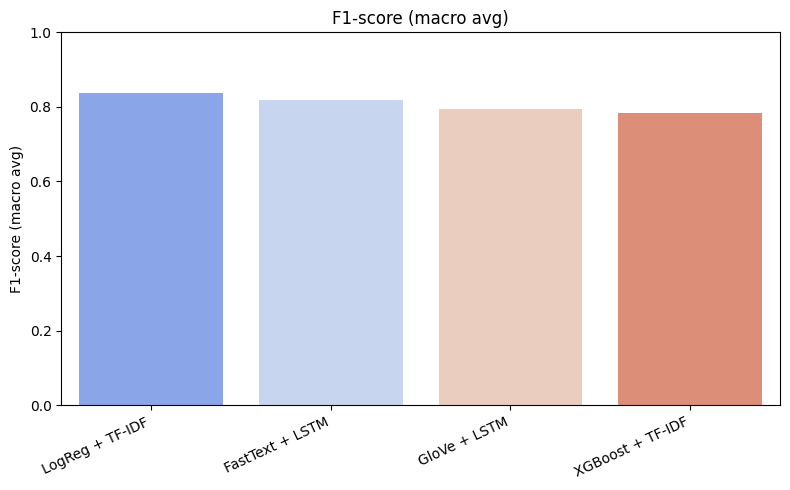

In [46]:
# Sort in descending order
df_sorted = df_results.sort_values(by='Macro avg F1', ascending=False)

models = df_sorted.index.tolist()
f1_macro = df_sorted['Macro avg F1'].values

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=f1_macro, palette='coolwarm')
plt.title("F1-score (macro avg)")
plt.ylabel("F1-score (macro avg)")
plt.ylim(0, 1)
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()


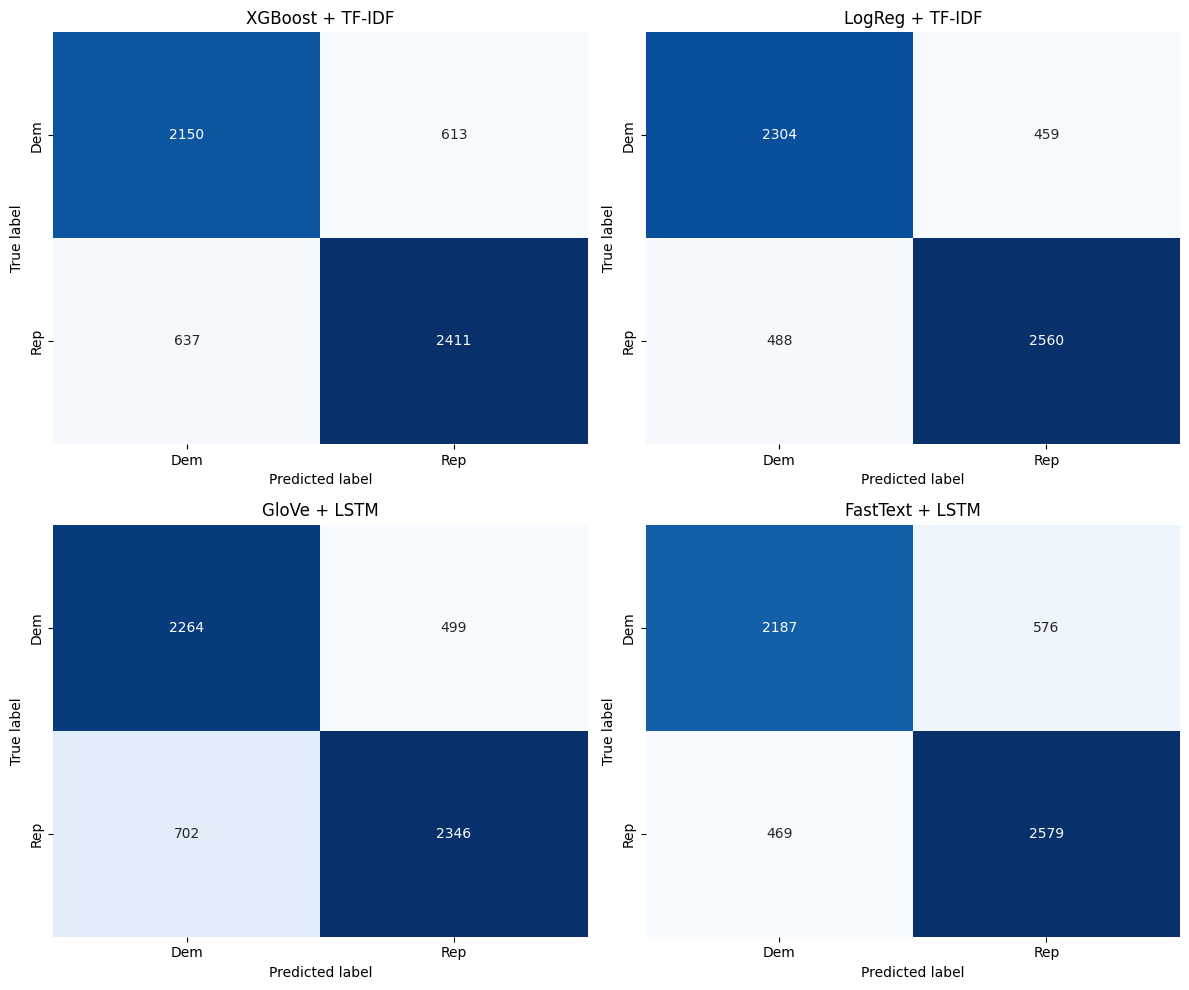

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# conf_xgb = confusion_matrix(y_test, y_pred_class_xgb)
# conf_log = confusion_matrix(y_test, y_pred_class_log)
conf_gv = confusion_matrix(y_test, y_pred_gv)
conf_ft = confusion_matrix(y_test, y_pred_ft)

cms = [conf_xgb, conf_log, conf_gv, conf_ft]
titles = ['XGBoost + TF-IDF', 'LogReg + TF-IDF', 'GloVe + LSTM', 'FastText + LSTM']

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.xaxis.set_ticklabels(['Dem', 'Rep'])
    ax.yaxis.set_ticklabels(['Dem', 'Rep'])

plt.tight_layout()
plt.show()

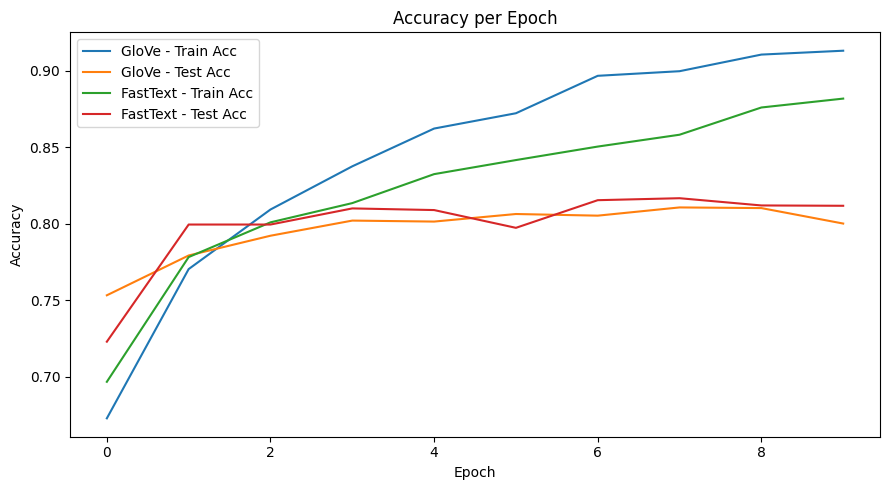

In [52]:
plt.figure(figsize=(9, 5))

plt.plot(history_gv.history['accuracy'], label='GloVe - Train Acc')
plt.plot(history_gv.history['val_accuracy'], label='GloVe - Test Acc')
plt.plot(history_ft.history['accuracy'], label='FastText - Train Acc')
plt.plot(history_ft.history['val_accuracy'], label='FastText - Test Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

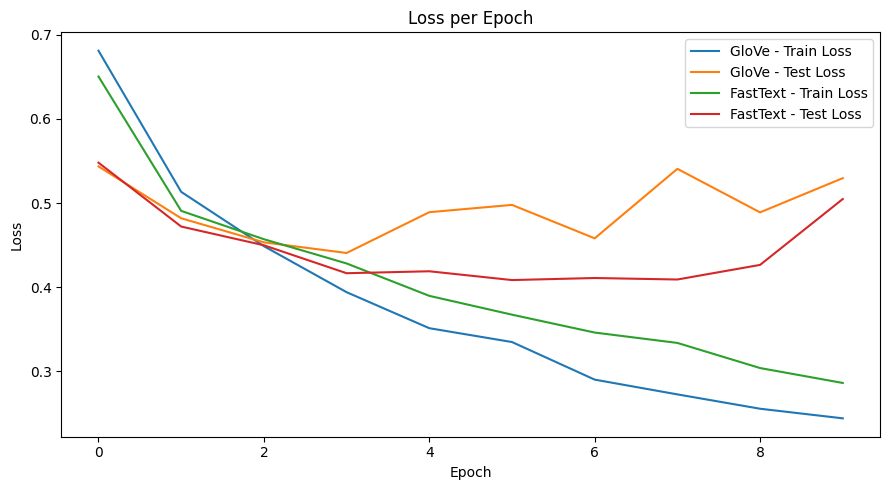

In [55]:
plt.figure(figsize=(9, 5))

plt.plot(history_gv.history['loss'], label='GloVe - Train Loss')
plt.plot(history_gv.history['val_loss'], label='GloVe - Test Loss')
plt.plot(history_ft.history['loss'], label='FastText - Train Loss')
plt.plot(history_ft.history['val_loss'], label='FastText - Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()